In [2]:
using StatsBase
using LinearAlgebra
using JuMP
using Gurobi
using CSV
using Distances
using PyPlot
using SparseArrays
using Printf

In [5]:
struct Pile
    points::Matrix{Float64} # 2 x n matrix where each column is a point
    weights::Vector{Float64}
end
Base.length(p::Pile) = length(p.weights)

function Base.rand(::Type{Pile}; n_points = rand(1:5),
                                 points = rand(2,n_points),
                                use_rand = true)
    if use_rand
        
        weights = rand(n_points)
#         weights = weights/sum(weights)
    else
        weights = ones(n_points)
#         weights = weights/sum(weights)
    end
    return Pile(points, weights)
end


In [8]:
P_dat = CSV.read("../data/artificial/P.csv"; header=false)
P_points = convert(Matrix, P_dat)'


Q_dat = CSV.read("../data/artificial/Q.csv"; header=false)
Q_points = convert(Matrix, Q_dat)'

P = rand(Pile, n_points = size(P_points)[2], points = P_points,use_rand = false)
Q = rand(Pile, n_points = size(Q_points)[2], points = Q_points, use_rand = false)

cost = pairwise(Euclidean(), P.points, Q.points; dims=2)

In [16]:
solCount = 1000
m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0,PoolGap = 0.01))

@variable(m, X[axes(cost,1), axes(cost,2)] ≥ 0, Int)
@objective(m, Min, cost ⋅ X)
@constraint(m,sum(X) .== min(sum(P.weights), sum(Q.weights)))
@constraint(m, X * ones(Int, length(Q)) .<= P.weights)
@constraint(m, X'ones(Int, length(P)) .<= Q.weights);
optimize!(m)
# solution = value.(X)

solution_pool = zeros(solCount, length(P),length(Q))
cnt = 0
for i in 0:(solCount-1)
    try
        setparam!(m.moi_backend.inner,"SolutionNumber", i)
        
        xn = Gurobi.get_dblattrarray(m.moi_backend.inner, "Xn", 1, length(X))
        xn_val = Gurobi.get_dblattr(m.moi_backend.inner, "PoolObjVal")
        
        default = zeros(length(P),length(Q))
        for i in 0:length(P)-1
            default[i+1,:] = xn[(i*length(Q))+1:(i+1)*length(Q)]
        end
        solution_pool[i+1,:,:] = default
        cnt+=1
    catch 
        break
    end
end
sol_pool = deepcopy(solution_pool[1:cnt,:,:]);

Optimize a model with 33 rows, 175 columns and 525 nonzeros
Variable types: 0 continuous, 175 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+00]
Presolve time: 0.00s
Presolved: 33 rows, 175 columns, 525 nonzeros
Variable types: 0 continuous, 175 integer (175 binary)

Root relaxation: objective 6.269101e+00, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       6.2691008    6.26910  0.00%     -    0s
Optimal solution found at node 0 - now completing solution pool...
     0     0          -    0         6.26910    6.26910  0.00%     -    0s
     0     0          -    0         6.26910    6.26910  0.00%     -    0s
     0     2          -    0         6.26910    6.26910  0.00%     -    0s

Explored 3857 n

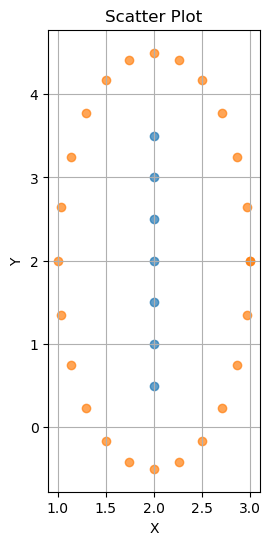

In [17]:
fig = figure("pyplot_scatterplot",figsize=(6,6))
ax = PyPlot.axes()
subplot(122)
# ax = fig[:add_subplot](1,2,2);
scatter(P.points[1,:],P.points[2,:],alpha=0.7)
scatter(Q.points[1,:],Q.points[2,:],alpha=0.7)

PyPlot.title("Scatter Plot")
xlabel("X")
ylabel("Y")
grid(true)
# gcf() # Needed for IJulia to plot inline

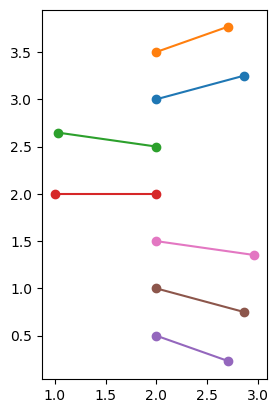

In [20]:
solOther = sparse(sol_pool[rand(1:cnt),:,:])
for (x,y,v) in zip(findnz(solOther)...)
    
    x_pos = [P.points[:,x][1], Q.points[:,y][1]]
    y_pos = [P.points[:,x][2], Q.points[:,y][2]]
    subplot(122)
    scatter(x_pos, y_pos)
    plot(x_pos, y_pos)
end